In [1]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dot, Add

In [2]:
from tensorflow.keras.layers import BatchNormalization

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras.optimizers import SGD, Adam

In [5]:
import tensorflow as tf

In [6]:
def import_hf5(data_path, data_name, get_name):
    hf = h5py.File(os.path.join(data_path, data_name), mode="r")
    data = hf.get(get_name)
    stack = np.array(data)
    hf.close()
    return stack

In [7]:
#code from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def normalise_01(image_data):
    stack = image_data
    image_data -= np.min(stack, axis=0)
    image_data /= (np.max(stack, axis=0) - np.min(stack, axis=0))
    return image_data

In [8]:
def standardise(image_data):
    image_data -= np.mean(image_data, axis=0, dtype=np.float32)
    image_data /= np.std(image_data, axis=0, dtype=np.float32)
    return image_data

In [9]:
def circle(train_lulc,test_lulc,title) :
    train_slum = (train_lulc==1).sum()
    train_noslum = (train_lulc==0).sum()
    test_slum = (test_lulc==1).sum()
    test_noslum = (test_lulc==0).sum()
    
    RESTRAIN = [train_slum,train_noslum]
    RESTEST = [test_slum,test_noslum]
    RESLABEL1 = ['Training slums', 'Training no slums' ]
    RESLABEL2 = ['Test slums', 'Test no slums']
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.pie(RESTRAIN, labels=RESLABEL1, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax2.pie(RESTEST, labels=RESLABEL2, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    
    plt.title(title)
    
    plt.show()

In [10]:
from osgeo import gdal
import numpy as np

#code inspired from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def stackage(list_raster):
    stack = []
    for patch in list_raster :
        pat = gdal.Open(patch)#.decode('ascii')
        data_rast = pat.ReadAsArray().astype(np.float32)
        data_rast = np.transpose(data_rast,(1,2,0))
        stack.append(data_rast)

    stack= np.array(stack)
    
    return stack


In [11]:
def assimilation(patch_id_train, patch_id_test, path_raster):
    train_path = [None] * 10
    test_path = [None] * 10

    patch_id_train_re = patch_id_train.reshape(1,patch_id_train.size)
    patch_id_train_list = patch_id_train_re.tolist()[0]
    patch_id_test_re = patch_id_test.reshape(1,patch_id_test.size)
    patch_id_test_list = patch_id_test_re.tolist()[0]
    
    train_path = [None] * len(patch_id_train)
    test_path = [None] * len(patch_id_test)
    
    for path in path_raster : #récupération des id des images
        image = path.split(b'/')[-1]
        image_id = int(image.split(b'_')[-2])
        if image_id in patch_id_train_list :
            index = patch_id_train_list.index(image_id)
            train_path[index] = path
        elif image_id in patch_id_test_list :
            index = patch_id_test_list.index(image_id)
            test_path[index] = path

    #stack = stackage(train_path)

    stack_train = stackage(train_path)
    #stack = stackage(test_path)
    stack_test = stackage(test_path)

    
    plt.rcParams["figure.facecolor"] = 'w'
    plt.figure(figsize=(15, 15))
    for i in range(3):
        rd_img = np.random.randint(1,500)
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(Norma_Xpercentile(stack_test[rd_img,:,:,:]))
        plt.axis("off")
        plt.title("Random indx: %s\nID: %s\nlulc: %0.3f" %(rd_img,patch_id_test[rd_img],patch_lulc_test[rd_img]))
        print(stack_test[rd_img,0,0,:])
        print(test_path[rd_img])
        print(patch_id_test[rd_img])
    #plt.subplots_adjust(hspace=0.001)
    plt.tight_layout() 
    
    stack_train = normalise_01(stack_train)
    stack_test = normalise_01(stack_test)


    return stack_train, stack_test

In [12]:
def make_csv(predict, patch_id_raster, name):
    import csv

    predict = predict.reshape(1,predict.size).tolist()[0]

    header = ['prob_slum','id']
    cont = []
    cont.append(header)
    for x,y in zip(predict,patch_id_raster):
        current_row = [x,y[0]]
        cont.append(current_row)

    cont

    with open(str(name)+'.csv','w') as file :
        write = csv.writer(file)
        write.writerows(cont)

In [13]:
def reshape(list_input):
    L = np.array(list_input)
    L = L.reshape(L.size,-1)
    
    return L

In [14]:
import h5py
import os, sys

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [16]:
# Add local module to the path
src = os.path.abspath('SRC/')
if src not in sys.path:
    sys.path.append(src)


In [17]:
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that checks and creates folder
from mkdir import check_create_dir
# Import functions for plots
from plots import plot_loss, plot_pred_test, plot_pred_train, plot_loss_multirun
# Import functions for metrics to monitoring accuracy
from metrics import coeff_determination
# Import functions for display
from display import Norma_Xpercentile
# Import functions for exportation of results
from export_results import save_predictions, write_run_metrics_file
# Import LRFinder function
from LRFinder import LRFinder

## Importing and pre-processing data

In [18]:
from chunckage import chunckage

S1_patch_path, S1_patch_id, S1_patch_lulc = chunckage("Images/big_raster/","ALLS1",".tif",'Images/big_sample/','sample.gpkg','tr_ALLS1',1)
S2_patch_path, S2_patch_id, S2_patch_lulc = chunckage("Images/big_raster/","BNIR",".tif",'Images/big_sample/','sample.gpkg','tr_BNIR',1)

(238890.0, 288990.0, 9846480.0, 9871580.0)
(238890.0, 288990.0, 9846480.0, 9871580.0)


In [19]:
S1_grid_path, S1_grid_id = chunckage("Images/big_raster/","ALLS1",".tif",'Images/big_grid/','grid.gpkg','g_ALLS1',0)
S2_grid_path, S2_grid_id = chunckage("Images/big_raster/","BNIR",".tif",'Images/big_grid/','grid.gpkg','g_BNIR',0)


(238890.0, 289090.0, 9846380.0, 9871680.0)
(238890.0, 289090.0, 9846380.0, 9871680.0)


In [20]:
data_path = 'Images/big_raster/tr_BNIR_patch/'
with h5py.File(os.path.join(data_path,"tr_Ymodel_S1BNIR.hdf5"), mode="a") as f:
    f["id_sar"] = S1_patch_id               
    f["id_rgb"] = S2_patch_id                 
    f["lulc_sar"] = S1_patch_lulc          
    f["lulc_rgb"] = S2_patch_lulc       
    f["patch_sar_path"] = S1_patch_path  
    f["patch_rgb_path"] = S2_patch_path

print("Data exported in %s"%(data_path))

Data exported in Images/big_raster/tr_BNIR_patch/


In [21]:
data_path = 'Images/big_raster/g_BNIR_patch/'
with h5py.File(os.path.join(data_path,"g_Ymodel_S1BNIR.hdf5"), mode="a") as f:
    f["id_sar"] = S1_grid_id               
    f["id_rgb"] = S2_grid_id                       
    f["patch_sar_path"] = S1_grid_path  
    f["patch_rgb_path"] = S2_grid_path

print("Data exported in %s"%(data_path))

Data exported in Images/big_raster/g_BNIR_patch/


## Preprocessing

In [18]:
import h5py

f = h5py.File('Images/big_raster/tr_BNIR_patch/tr_Ymodel_S1BNIR.hdf5', 'r')
S1_patch_id = np.array(f["id_sar"])
S2_patch_id = np.array(f["id_rgb"])
S1_patch_lulc = np.array(f["lulc_sar"])
S2_patch_lulc = np.array(f["lulc_rgb"])
S1_patch_path = f["patch_sar_path"]
S2_patch_path = f["patch_rgb_path"]
                         
f = h5py.File('Images/big_raster/g_BNIR_patch/g_Ymodel_S1BNIR.hdf5', 'r')
S1_grid_id = np.array(f["id_sar"])          
S2_grid_id = np.array(f["id_rgb"])                     
S1_grid_path = f["patch_sar_path"]
S2_grid_path = f["patch_rgb_path"]

In [19]:
stack = stackage(S1_grid_path)
S1_stack_grid = normalise_01(stack)

stack = stackage(S2_grid_path)
S2_stack_grid = normalise_01(stack)

In [20]:
S1_patch_id = S1_patch_id.reshape(S1_patch_id.size,1)
S2_patch_id = S2_patch_id.reshape(S2_patch_id.size,1)
S1_patch_lulc = S1_patch_lulc.reshape(S1_patch_lulc.size,1)
S2_patch_lulc = S2_patch_lulc.reshape(S2_patch_lulc.size,1)
S1_grid_id = S1_grid_id.reshape(S1_grid_id.size,1)
S2_grid_id = S2_grid_id.reshape(S2_grid_id.size,1)

In [21]:
patch_id_train, patch_id_test, patch_lulc_train, patch_lulc_test = train_test_split(S1_patch_id,S1_patch_lulc, test_size=0.2, random_state=100)
patch_id_train = reshape(patch_id_train)
patch_id_test = reshape(patch_id_test)
patch_lulc_train = reshape(patch_lulc_train)
patch_lulc_test = reshape(patch_lulc_test)   

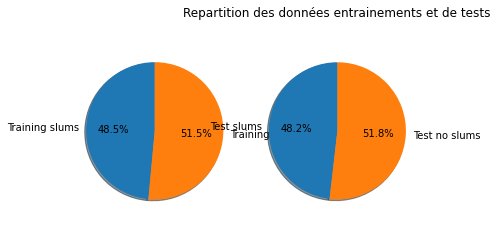

In [49]:
circle(patch_lulc_train,patch_lulc_test,'Repartition des données entrainements et de tests')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1262. 2116. 2133. 2554.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_123583_0.tif'
[123583]
[1222. 2314. 2376. 2548.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_69376_0.tif'
[69376]
[2676. 2648. 3086. 5315.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_37878_1.tif'
[37878]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1302. 1910. 2220. 2161.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_75078_0.tif'
[75078]
[ 805. 2774. 2873. 1901.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_93995_0.tif'
[93995]
[1180. 2370. 2329. 2252.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_18869_1.tif'
[18869]


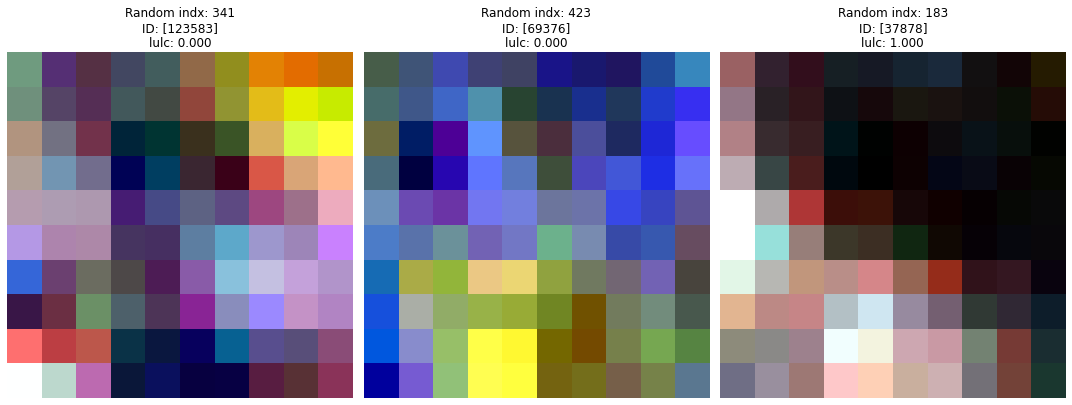

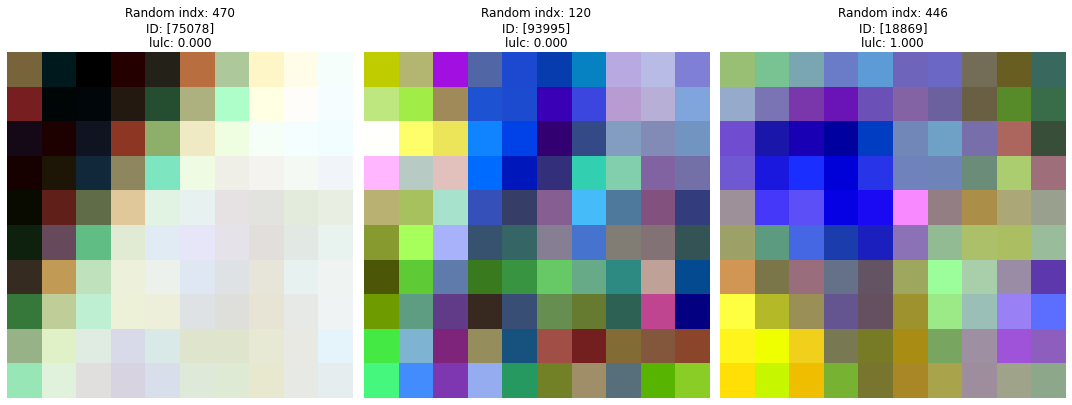

In [22]:
stack_train = assimilation(patch_id_train, patch_id_test, S2_patch_path)[0]
stack_test = assimilation(patch_id_train, patch_id_test, S2_patch_path)[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.3247942 -11.599849  -16.535933 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_55258_0.tif'
[55258]
[  0.68250865  -1.0776927  -12.45175   ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_39894_1.tif'
[39894]
[  0.45142475  -4.515901   -14.678779  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_63669_1.tif'
[63669]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.53139985  -6.9365396  -11.190658  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_71259_0.tif'
[71259]
[  0.3552604  -9.921181  -15.426327 ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_69739_0.tif'
[69739]
[  0.60060513  -6.06656    -11.322604  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_55825_0.tif'
[55825]


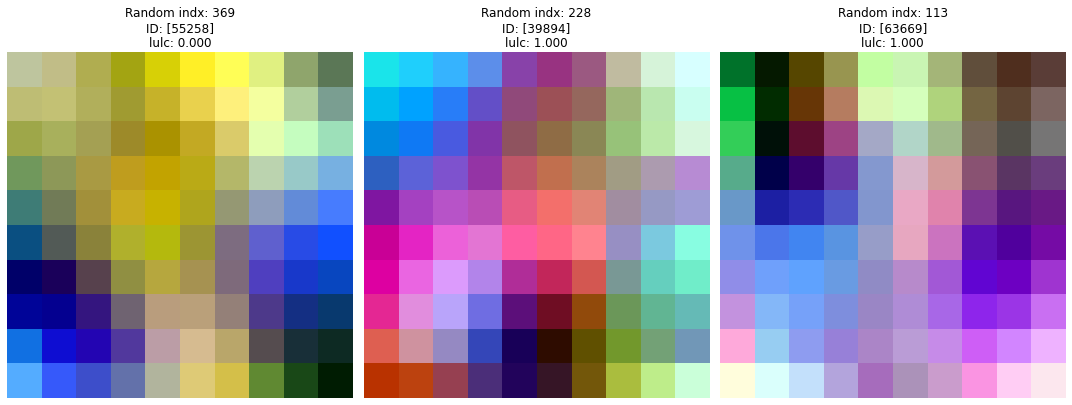

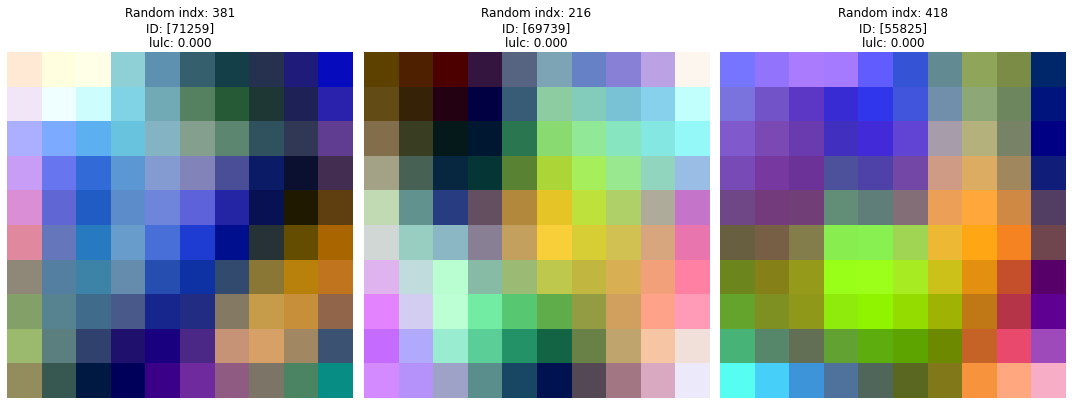

In [23]:
stack_sar_train = assimilation(patch_id_train, patch_id_test, S1_patch_path)[0]
stack_sar_test = assimilation(patch_id_train, patch_id_test, S1_patch_path)[1]

## Model definition

In [32]:
def ymodel(left_input_shape,right_input_shape,batch_size,kernel_size,dropout,n_filters,stack_train,stack_test,stack_sar_train,stack_sar_test):
    
    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs = {}):
            if logs.get('val_accuracy') > 0.98:
              print("\n Enough accuracy")
              self.model.stop_training = True

    maxcallbacks = myCallback()
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min')
    
    myCallbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(filepath='Images/checkpoint', save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True),
                   maxcallbacks, 
                   tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.001) ]
    
    #Left branch
    
    left_inputs = Input(shape=left_input_shape)
    x = left_inputs
    filters = n_filters

    x = RandomFlip("horizontal_and_vertical")(x)
    x = RandomRotation(0.2, fill_mode='reflect')(x)
    #x = RandomTranslation(height_factor=0.05, width_factor=0.05, fill_mode='reflect')(x) 

    # 2 layer of Conv2D-Dropout-MaxPooling2D
    for i in range(2):
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding='same',
                   activation='relu')(x)
        x = BatchNormalization(axis=-1)(x)
        x = Dropout(dropout)(x)
        filters *= 2
        
    x = MaxPooling2D()(x)
    
    
    right_inputs = Input(shape=right_input_shape)
    y = right_inputs
    filters = n_filters



    #Right branch

    
    y = RandomFlip("horizontal_and_vertical")(y)
    y = RandomRotation(0.2, fill_mode='reflect')(y)
    #y = RandomTranslation(height_factor=0.05, width_factor=0.05, fill_mode='reflect')(y) 
    
    # 2 layer of Conv2D-Dropout-MaxPooling2D
    
    for i in range(2):
        y = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding='same',
                   activation='relu',
                   dilation_rate=2)(y)
        y = BatchNormalization(axis=-1)(y)
        y = Dropout(dropout)(y) 
        filters *= 2

    y = MaxPooling2D()(y)
       
    
    # merge left and right branches outputs
    z = concatenate([x, y])
    
    # feature maps to vector before connecting to Dense 
    #num_labels = (0,1)
    z = Flatten()(z)

    z = Dense(512,activation='relu')(z)

    outputs = Dense(1, activation="sigmoid")(z)
    
    
    model = Model([left_inputs, right_inputs], outputs)
    
    model.summary()
    
    model.compile(loss="binary_crossentropy",
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])
    
    history = model.fit([stack_train, stack_sar_train],
          patch_lulc_train, 
          validation_data=([stack_test, stack_sar_test], patch_lulc_test),
          epochs=100,
          batch_size=batch_size, callbacks=[myCallbacks])
    
    score = model.evaluate([stack_test, stack_sar_test],
                       patch_lulc_test,
                       batch_size=batch_size,
                       verbose=0)
    
    model.load_weights('Images/checkpoint')
    predict = model.predict([S2_stack_grid, S1_stack_grid])
    
    layers = model.layers
    
    tf.keras.utils.plot_model(
                                model,
                                to_file="Images/model.png",
                                show_shapes=True,
                                show_dtype=True,
                                show_layer_names=True,
                                rankdir="TB",
                                expand_nested=False,
                                dpi=96,
                                layer_range=None,
                                show_layer_activations=True,
                                )

    
    print(score)
    
    return history, predict, layers, model

In [33]:
from keras import backend as K
K.clear_session()

In [34]:
left_input_shape = (10,10,4)
right_input_shape = (10,10,3)
batch_size = 32
kernel_size = 3
dropout = 0.5
n_filters = 32

In [35]:
output = ymodel(left_input_shape,right_input_shape,batch_size,kernel_size,dropout,n_filters,stack_train,stack_test,stack_sar_train,stack_sar_test)
history = output[0]
predict = output[1]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 random_flip (RandomFlip)       (None, 10, 10, 4)    0           ['input_1[0][0]']                
                                                                                                  
 random_flip_1 (RandomFlip)     (None, 10, 10, 3)    0           ['input_2[0][0]']                
                                                                                              

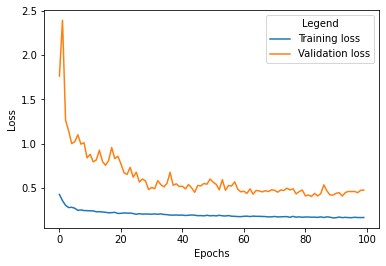

In [46]:
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training loss','Validation loss'], title = "Legend")
plt.show()

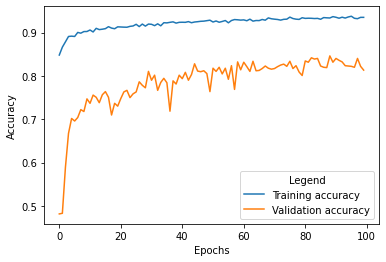

In [45]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy','Validation accuracy'], title = "Legend")
plt.show()

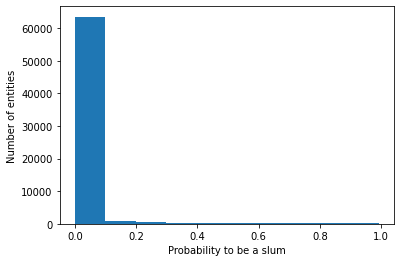

In [47]:
plt.hist(predict)
plt.xlabel('Probability to be a slum')
plt.ylabel('Number of entities')
plt.show()

In [39]:
print(max(predict))

[0.99315166]


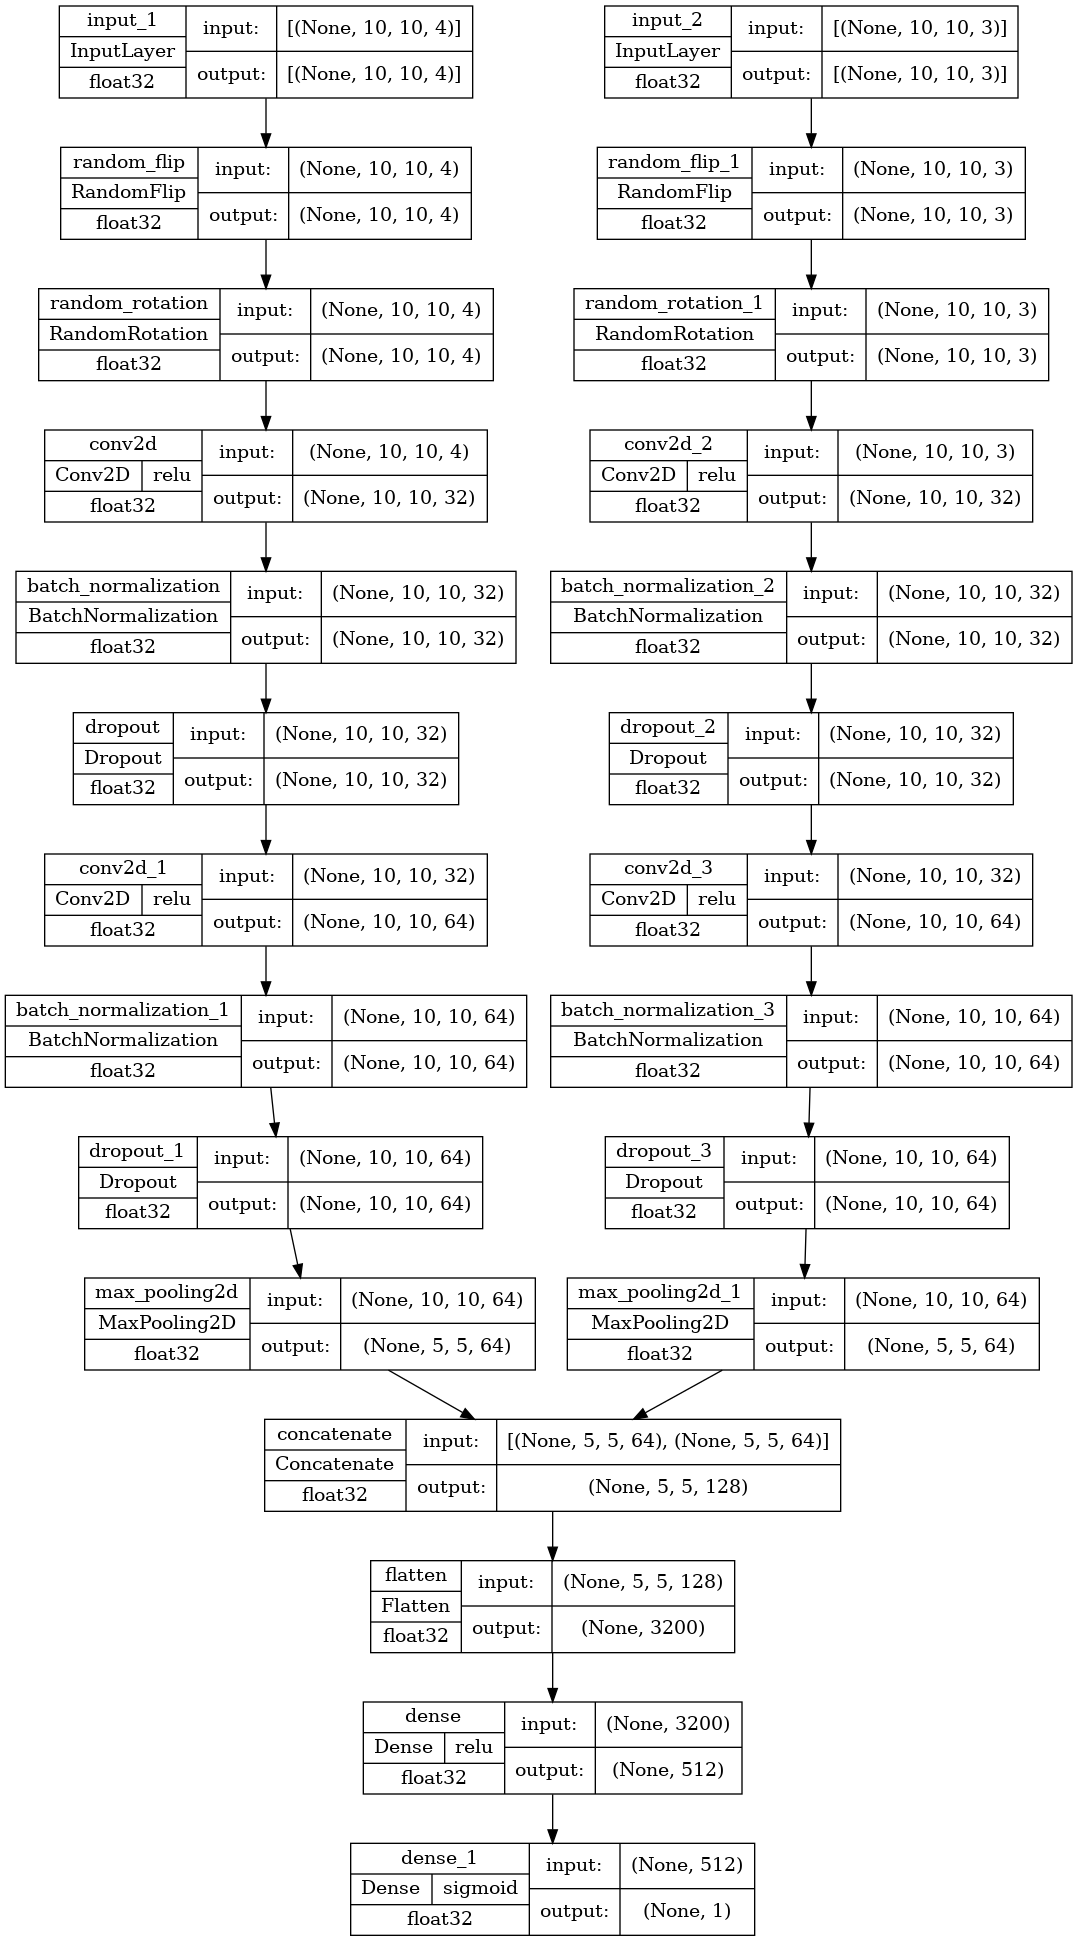

In [41]:
model = output[3]
tf.keras.utils.plot_model(
                                model,
                                to_file="Images/Ymodel.png",
                                show_shapes=True,
                                show_dtype=True,
                                show_layer_names=True,
                                rankdir="TB",
                                expand_nested=False,
                                dpi=96,
                                layer_range=None,
                                show_layer_activations=True,
                                )

In [48]:
make_csv(predict, S1_grid_id,'y_S1S2_BNIR')

In [121]:
from osgeo import ogr

diff = []
diff.append(['id','diff'])
mach_res = ogr.Open('CLUSTERS/nairobi_grid100_clust_morpho_10pc_10cl.shp')
mach_layer = mach_res.GetLayer()
for mach_patch in mach_layer :
    probstab = mach_patch.GetField('probstab')
    mach_id = mach_patch.GetField('id')
    index = S1_grid_id.index(mach_id)
    if probstab != None :
        line = [int(mach_id),predict[index,0] - probstab]
        diff.append(line)
    else :
        line = [int(mach_id),None]
        diff.append(line)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [ ]:
import csv

name = 'machVSdeep2'

with open(str(name)+'.csv','w') as file :
    write = csv.writer(file)
    write.writerows(diff)

In [ ]:
print(diff)

In [ ]:
import os, signal

os.kill(os.getpid() , signal.SIGKILL)